In [1]:
using PGFPlots
using Distributions
using BayesNets

## Piecewise Constant Distributions

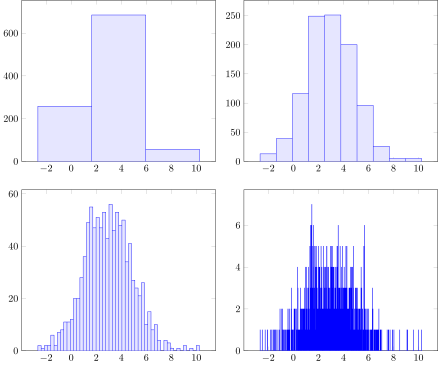

In [2]:
# define a normal distribution with mean 3 and standard deviation 2
dist = Normal(3,2)
# generate 1000 samples
d = rand(dist, 1000)
# try out histograms with a variety of different number of bins
bins = [3 10 50 1000]
g = GroupPlot(2,2)
for i = 1:length(bins)
    push!(g, Axis(Plots.Histogram(d, bins=bins[i]), ymin=0))
end
g

Of course, these plots are not of densities (they do not integrate to 1).

## Mixture Model

This example will focus on Gaussian mixture components, but the code can support components from other distributions.

In [3]:
function mix_pdf(d::MixtureModel, x)
    sum([probs(d.prior)[i] * pdf(d.components[i], x) for i in 1:length(d.components)])
end;

In [4]:
dist = MixtureModel([Normal(-3,1), Normal(4,2)], [0.8, 0.2])

MixtureModel{Distributions.Normal{Float64}}(K = 2)
components[1] (prior = 0.8000): Distributions.Normal{Float64}(μ=-3.0, σ=1.0)
components[2] (prior = 0.2000): Distributions.Normal{Float64}(μ=4.0, σ=2.0)


In [5]:
function draw_rand(d::MixtureModel, n)
    # create an array c holding random components (based on weights)
    c = wsample(1:length(d.components), probs(d.prior), n)
    # randomly generate sample from appropriate component distribution
    convert(Vector{Float64}, [rand(d.components[c[i]]) for i = 1:n])
end;

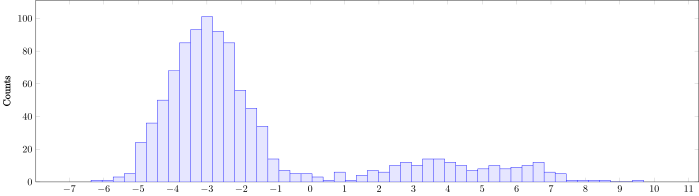

In [6]:
d = draw_rand(dist, 1000)
a = Axis(Plots.Histogram(d, bins=50), ymin=0, ylabel="Counts", width="25cm", height="8cm")

Note the two bumps!

## Conditional Probability Distributions

### Binary

There are many types of conditional probability distributions. Here we'll focus on those with binary variables whose distribution can be specified using as table.

In [7]:
target = :C
parents = [:B, :S]
parental_ncategories = [2, 2] # B and S can each be 1 or 2
distributions = [Bernoulli(0.8), # B = 1, S = 1
                 Bernoulli(0.2), # B = 2, S = 1
                 Bernoulli(0.3), # B = 1, S = 2
                 Bernoulli(0.5)] # B = 2, S = 2
cpd = CategoricalCPD(target, parents, parental_ncategories, distributions);

Let's make an assignment of variables to values.

In [8]:
a = Assignment(:B=>1, :S=>2)

Dict{Symbol,Any} with 2 entries:
  :B => 1
  :S => 2

In [9]:
pdf(cpd(a), true)

0.3

### Linear Gaussian

$$\mathcal{N}(\mu = a\cdot x + b, \sigma)$$

The constructor of CPDs.Normal takes a function mapping an assignment to
a tuple of parameters (i.e., mean and variance) for the Normal distribution

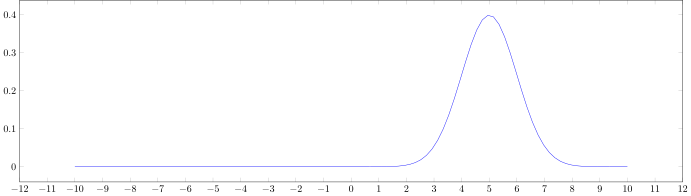

In [10]:
a = [5.0]; b = 0.0; σ = 1.0
cpd = LinearGaussianCPD(:y, [:x], a, b, σ)

PGFPlots.Axis(Plots.Linear(x->pdf(cpd(:x=>1.0), x), (-10, 10)), width="25cm", height="8cm")

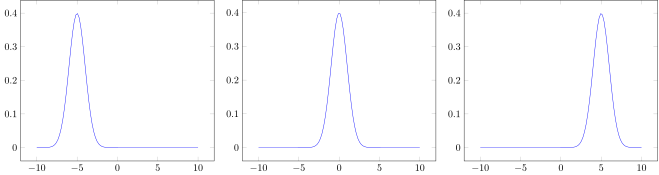

In [11]:
g = GroupPlot(3,1)
for x in -1:1
    push!(g, Plots.Linear(j->pdf(cpd(:x=>x), j), (-10, 10)))
end
g

## Bayesian Networks

A Bayesian network is a directed acyclic graph comprised of conditional probability distributions.

  likely near C:\Users\Mykel\.julia\v0.6\IJulia\src\kernel.jl:31
  likely near C:\Users\Mykel\.julia\v0.6\IJulia\src\kernel.jl:31
  likely near C:\Users\Mykel\.julia\v0.6\IJulia\src\kernel.jl:31
  likely near C:\Users\Mykel\.julia\v0.6\IJulia\src\kernel.jl:31
  likely near C:\Users\Mykel\.julia\v0.6\IJulia\src\kernel.jl:31
  likely near C:\Users\Mykel\.julia\v0.6\IJulia\src\kernel.jl:31
  likely near C:\Users\Mykel\.julia\v0.6\IJulia\src\kernel.jl:31
  likely near C:\Users\Mykel\.julia\v0.6\IJulia\src\kernel.jl:31
  likely near C:\Users\Mykel\.julia\v0.6\IJulia\src\kernel.jl:31
  likely near C:\Users\Mykel\.julia\v0.6\IJulia\src\kernel.jl:31
  likely near C:\Users\Mykel\.julia\v0.6\IJulia\src\kernel.jl:31
  likely near C:\Users\Mykel\.julia\v0.6\IJulia\src\kernel.jl:31


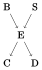

In [12]:
bn = DiscreteBayesNet()
push!(bn, DiscreteCPD(:B, [0.1,0.9]))
push!(bn, DiscreteCPD(:S, [0.5,0.5]))
push!(bn, rand_cpd(bn, 2, :E, [:B, :S]))
push!(bn, rand_cpd(bn, 2, :D, [:E]))
push!(bn, rand_cpd(bn, 2, :C, [:E]))

Let's compute the probability of an assignment using the chain rule.

In [13]:
a = Assignment(
    :B=>1,
    :S=>2,
    :E=>1,
    :D=>2,
    :C=>2
)

Dict{Symbol,Any} with 5 entries:
  :D => 2
  :B => 1
  :S => 2
  :E => 1
  :C => 2

Here are the conditional probabilities.

In [14]:
[pdf(get(bn, name), a) for name in names(bn)]

5-element Array{Float64,1}:
 0.1      
 0.5      
 0.0168261
 0.430004 
 0.447977 

In [15]:
prod([pdf(get(bn, name), a) for name in names(bn)])

0.0001620620345751831

The library implements this for you:

In [16]:
pdf(bn, a)

0.0001620620345751831